In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
import wandb
import random
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api")

In [ ]:
# Login to wandb
wandb.login(key=wandb_api)

# 1. Explore the dataset through code

### a) How many images does the dataset contain?

In [ ]:
# Count the images in the test-, train-, and validation folders.
data_folder = Path("/kaggle/input/fruit-and-vegetable-image-recognition/")
test_folder = data_folder / "test"
train_folder = data_folder / "train"
validation_folder = data_folder / "validation"

print(f'Total files in dataset: {sum(1 for file in data_folder.rglob("*") if file.is_file())} folders')
print(f'Files in test folder: {sum(1 for file in test_folder.rglob("*") if file.is_file())} folders')
print(f'Files in train folder: {sum(1 for file in train_folder.rglob("*") if file.is_file())} folders')
print(f'Files in validation folder: {sum(1 for file in validation_folder.rglob("*") if file.is_file())} folders')

### b) How many classes? How many images per class? Show a histogram of the number of instances per class.

In [ ]:
def plot_histogram(class_count_dictionary):
    classes = list(class_count_dictionary.keys())
    counts = list(class_count_dictionary.values())
    
    # Create the bar chart
    plt.figure(figsize=(12, 6))  # Set figure size
    plt.bar(classes, counts, color='skyblue')
    
    # Labeling
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Number of Images per Class', fontsize=14)
    plt.xticks(rotation=90)  # Rotate class names for readability

    # Show the plot
    plt.show()

In [ ]:
# Print number of classes in the dataset
n_classes_test = [x for x in test_folder.glob("*") if not x.is_file()]
n_classes_train = [x for x in train_folder.glob("*") if not x.is_file()]
n_classes_validation = [x for x in validation_folder.glob("*") if not x.is_file()]

print(f'Amount of classes: {len(n_classes_test)}')

# Compute avg number of images per class
class_count_test = {}
class_count_train = {}
class_count_validation = {}

# Count images per class in the test split
for class_ in n_classes_test:
    counter = 0
    for file in class_.glob("*"):
        if file.is_file():
            counter += 1
    class_count_test[class_.name] = counter

# Count images per class in the train split
for class_ in n_classes_train:
    counter = 0
    for file in class_.glob("*"):
        if file.is_file():
            counter += 1
    class_count_train[class_.name] = counter

# Count images per class in the validation split
for class_ in n_classes_validation:
    counter = 0
    for file in class_.glob("*"):
        if file.is_file():
            counter += 1
    class_count_validation[class_.name] = counter

print(f'Average images per class in test-split: {sum(class_count_test.values()) / len(class_count_test)}')
print(f'Average images per class in train-split: {sum(class_count_train.values()) / len(class_count_train)}')
print(f'Average images per class in validation-split: {sum(class_count_validation.values()) / len(class_count_validation)}')


In [ ]:
# Plot histogram for test-split:
plot_histogram(class_count_test)

In [ ]:
# Plot histogram for train-split:
plot_histogram(class_count_train)

In [ ]:
# Plot histogram for validation-split:
plot_histogram(class_count_validation)

### c) Show 4 random images from each class

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

test_images = Path("/kaggle/input/fruit-and-vegetable-image-recognition/test")

for class_folder in test_images.iterdir():
    image_files = list(class_folder.glob("*.*"))

    selected_images = random.sample(image_files, 4)  # Select 4 random images
        
    # Display images
    fig, axes = plt.subplots(1, len(selected_images), figsize=(12, 4))
    for img_path, ax in zip(selected_images, axes):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")
        
    plt.show()


### d) Describe if/how you think the data distribution will affect training of a classifier.

A model might overfit to classes with higher representation in the training data. This means that we may get more false positives for those classes and fewer true positives for the rest of the classes. To mitigate this, data balancing can be done with eg. augmented data or training on a subset of the available data though this may introduce other problems.

### e) Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice. 

As stated in d) we could benefit from choosing a subset of the available data. However, it is important to have representation from all classes that we want to be able to classify with our model. More data is also preferable as the model will be more generalized.


# 2. Use a neural network of your own choice to classify the dataset. Explain your choice and at least one alternative. Document your experiences:


In [ ]:

import torch 
import torchvision 
from torchinfo import torchinfo
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import cv2 
from PIL import Image 
from tqdm import tqdm

class FruitsAndVeggies(Dataset):
    def __init__(self, split_root, transforms):
        # create a dict of labels and filepaths
        class_dir_names = sorted(os.listdir(split_root))
        n_classes = len(class_dir_names)
        self.transforms = transforms
        # create one-hot encoding 
        self.dataset_list = []
        for i, class_dir in enumerate(class_dir_names):
            label = torch.zeros(n_classes)
            label[i] = 1
            
            extension_set = {"jpg", "png",  "JPG", "jpeg"}

            for image in sorted(os.listdir(os.path.join(split_root, class_dir))):
                extension = image.split(".")[-1]

                if extension in extension_set:
                    self.dataset_list.append([label, os.path.join(split_root,class_dir,image)])
                else:
                    print(f"{extension} found in dataset")
        
    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, index):
        data_list = self.dataset_list[index]
        image_path = data_list[1]
        #label = data_list[0]
        label = torch.argmax(data_list[0])  # Converts one-hot to class index
        image = Image.open(image_path)
       

        if image.mode != "RGB":
            image = image.convert("RGB")

        image = self.transforms(image)

        return image, label    

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

# Hyperparameters
epochs = 10
learning_rate = 1e-4
batch_size = 32

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

# Load dataset
path_to_data = "/kaggle/input/fruit-and-vegetable-image-recognition/"
train_dataset = FruitsAndVeggies(os.path.join(path_to_data, "train"), transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_dataset = FruitsAndVeggies(os.path.join(path_to_data, "validation"), transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_dataset = FruitsAndVeggies(os.path.join(path_to_data, "test"), transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Get number of classes
num_classes = len(os.listdir(os.path.join(path_to_data, "train")))


class CustomCNN(nn.Module):
    def __init__(self, num_classes, num_conv_layers=3, num_filters=32, kernel_size=3, fc_neurons=256):
        super(CustomCNN, self).__init__()

        layers = []
        in_channels = 3
        out_channels = num_filters

        for i in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = out_channels
            out_channels *= 2  # Increase filters for deeper layers

        self.conv_layers = nn.Sequential(*layers)

        # Compute flattened feature size dynamically (assuming input is 224x224)
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, 224, 224)
            sample_output = self.conv_layers(sample_input)
            flattened_size = sample_output.view(1, -1).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, fc_neurons),
            nn.ReLU(),
            nn.Linear(fc_neurons, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten before fully connected layers
        x = self.fc_layers(x)
        return x

In [ ]:
sweep_config = {
    "method": "grid",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [1e-3, 1e-4, 1e-5]},
        "batch_size": {"values": [16, 32, 64]},
        "num_conv_layers": {"values": [2, 3, 4]},
        "epochs": {"values": [10, 15, 20]},
    }
}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Mini-project")


In [ ]:
def train():
    # Initialize wandb for this specific run
    run = wandb.init(entity="avs-846")

    # Load hyperparameters from wandb.config
    learning_rate = wandb.config.learning_rate
    batch_size = wandb.config.batch_size
    num_conv_layers = wandb.config.num_conv_layers

    # Update data loaders with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize the model with dynamic parameters
    model = CustomCNN(num_classes=num_classes, num_conv_layers=num_conv_layers)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with tqdm
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training", leave=False)

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_accuracy = 100 * train_correct / total_train
        avg_train_loss = train_loss / len(train_loader)

        # Validation loop with tqdm
        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} Validation", leave=False)

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        val_accuracy = 100 * val_correct / total_val
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Log metrics to wandb
        wandb.log({
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })

    # Final Test Accuracy
    model.eval()
    test_correct, total_test = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            test_correct += (outputs.argmax(1) == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * test_correct / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    wandb.log({"test_accuracy": test_accuracy})

    wandb.finish()


In [ ]:
wandb.agent(sweep_id, function=train, count=81)



### a) Discuss at least four relevant hyper-parameters

Learning rate:
The learning rate is important as it determines how rigid the model weights are during training. With a low learning rate, the weights will change very slowly which can result in long training time. It can also result in the model being "caught" in a local minimum. On the other hand, if the learning rate is too high, it can result in the model not being able to converge at a minimum, as it "overshoots" at every step.

Learning decay:
The learning decay is a hyperparameter that can help to mitigate some of the problems with the learning rate. Though it has not been used in this case, it could be implemented to control the training step even more. The learning decay makes it possible to decrease the learning rate during training, giving the model the opportunity to quickly approach a good result and later on slowly increment towards a minimum loss to avoid overshooting.

Epochs:
The number of epochs determines how long the model should be training for. If the model does not train long enough, it may still be able to improve, and with too many epochs, the model could start overfitting. A good way of avoiding this is to use validation data to validate after each epoch. If at some point the validation loss starts increasing while the training loss is still decreasing, it is a good indication that the model is being overfitted to the training data.

Batch size:
The batch size determines how much of the data we are working with at once. This means that the weights are only updated after each batch. Larger batch sizes will likely positively impact the generalization capabilities of the model, as weights will be updated to fit several different inputs at the same time and not hyperfixate on a single input at every iteration. However, as the entire batch is loaded into memory at the same time, it is quite memory intensive. Generalization can also be too much, and the model might become biased and unable to handle edge cases.

### b) Experiment with the effect of different batch sizes
### c) Experiment with the effect of different learning rates
### d) Experiment with different number of network layers


Different hyperparameters were tested with wandb's sweep function. The results from different combinations are shown in the figure below.
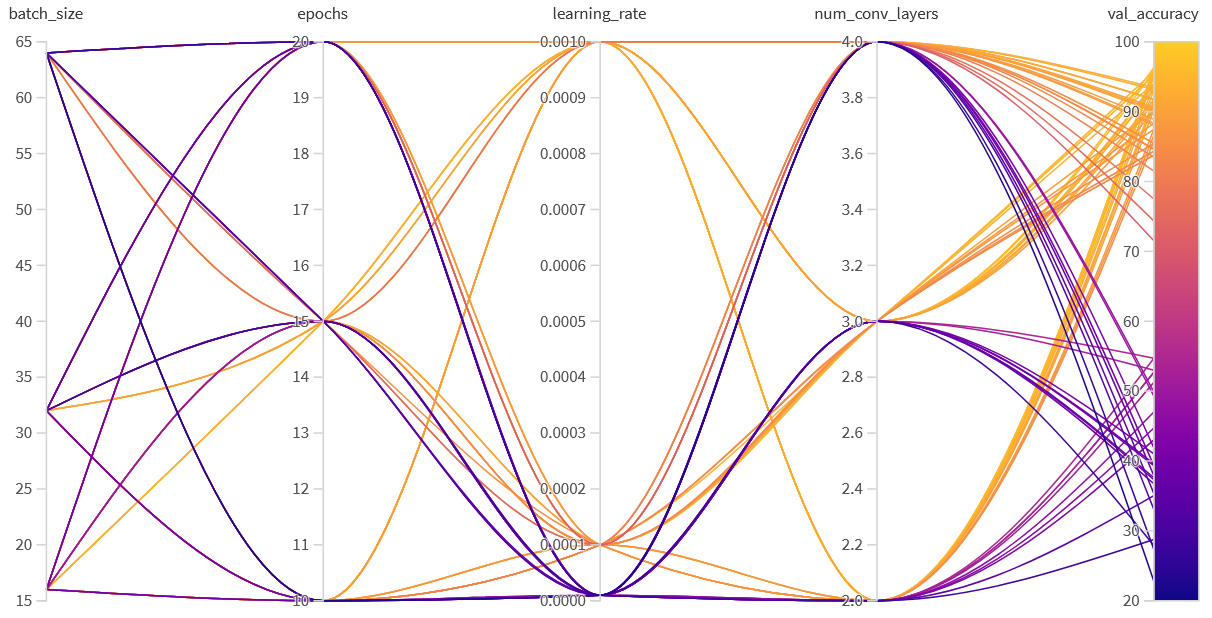
Note that the best performing models often have a higher learning rate. This is likely because of the relatively low number of epochs, which meant that lower learning rates did not have time to converge.


### e) Implement at least two data augmentation techniques. Motivate your choices.
We tried several different data augmentation techniques as shown below.
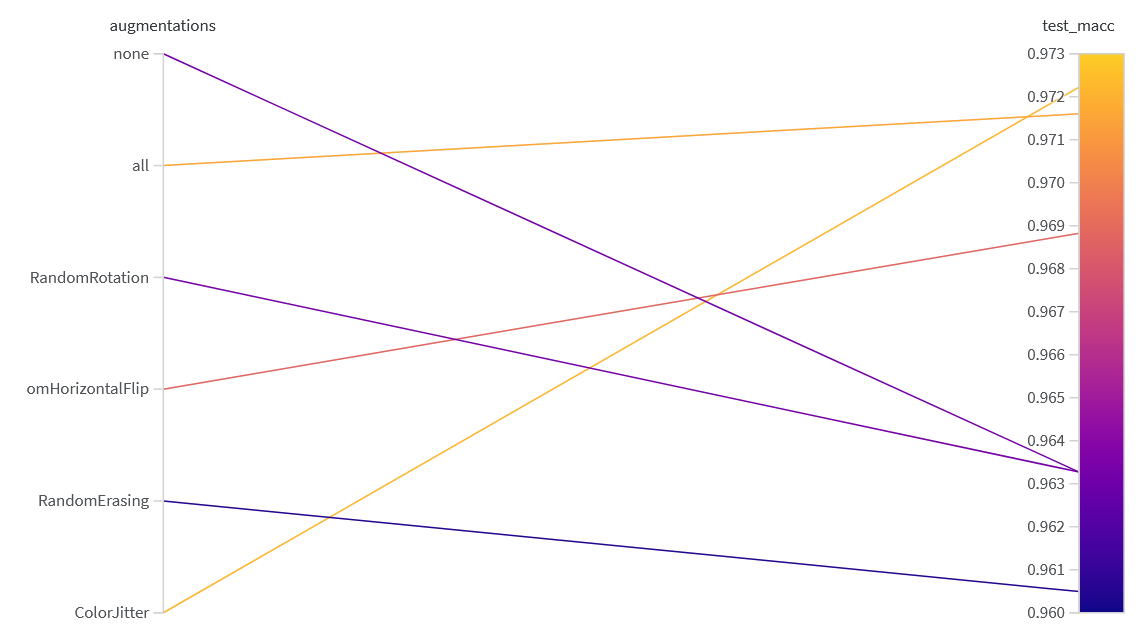
Though it can be seen that the color jitter augmentation performed the best, it is worth noting that all augmentations provided similar results with just above 1% difference in performance. 
It makes sense that color jitter performs well, as fruit and vegetables can vary in color even within the same class. The motivation for choosing random erasing was to teach the model to generalize by omitting some data. This was unsuccesful, likely related to the low amount of data.

### f) Discuss what influences the memory use of a solution such as yours. What can be done to reduce this?

The two most memory intensive aspects of the models, are the model architecture, as larger models have more weights that can be tuned, and the batch size, as it determines how much data is loaded at once.

### g) Make sure to distribute the experiments between group members. Include a plot in the report that shows user id vs. e.g. performance metric. To do this, make sure that a user id is logged as one of the parameters to wandb.

All group members have been working on the mini-project, though because of the way the sweep function works, one member has gotten credit from all iterations during a sweep. The figure below shows that everyone has been doing runs with their own id. The id's with a high number of runs, have been doing sweeps.

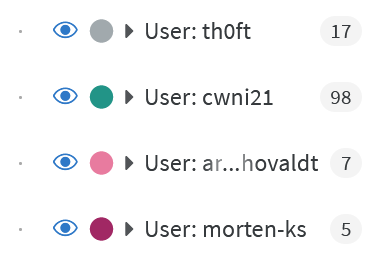

# 3. Break down the results of your classifier. Some suggestions:

### a) Which classes are easy and which are hard? Discuss why.

### b) Show five examples where the classification went well, and five where the classification failed. What could be some reasons that classification failed and what can be done to improve?